# MALCOM: Machine Learning for Communication Systems
## Lab Assignment #2
### Jeanne Barthélemy

In the two following code cells below is the completed code from the shared .py file :

   ### 1) Imports

In [1]:
# importing libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input, Dense, GaussianNoise, Lambda, BatchNormalization
from tensorflow.keras.models import Model  
#from keras.layers import ActivityRegularization
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD  

from tensorflow.keras import backend as K
import numpy as np 
import random as rd
import matplotlib.pyplot as plt 

print("loading complete")

loading complete


### 2) Model definition , compilation, & tests

In [2]:
def testModel(k= 2, n=2, fixedEnergyConstraint = True, questionD = False, nonlinearD1 = False, nonlinearD2 = False, questionE = False,increaseNbrLayer = False):
    
    # Initialization - Autoencoder (n,k)
    # M: number of messages to encode
    # k = log2(M)
    # n real-value signals (otherwise. for complex-valued signals, 2*n real numbers)
    k = k
    n = n
    M = 2**k
    R = k/n

    print(" ********* Testing autoencoder architecture ********* ")
    print(" ")
    print('M:',M,'\t','k:',k,'\t','n:',n)
    print(" ")

    # Channel parameters
    Eb_No_dB = 7
    noise = 1/(10**(Eb_No_dB/10))
    noise_sigma = np.sqrt(noise)
    beta = 1/(2*R*(10**(Eb_No_dB/10)))
    beta_sqrt = np.sqrt(beta)


    # Creating a training set and test set 
    eye_matrix = np.eye(M)
    x_train = np.tile(eye_matrix, (1000, 1))  
    x_test = np.tile(eye_matrix, (100, 1)) 
    rd.shuffle(x_train)
    rd.shuffle(x_test)


    # Printing the shape of x_train and x_test
    print(x_train.shape)  
    print(x_test.shape) 


    #Bit Error Rate
    def BER(y_true, y_pred):
        return K.mean(K.not_equal(y_true, K.round(y_pred)), axis=-1)  


    # Autoencoder definition/construction

    # Take the input and convert it to Keras tensors
    input_signal = Input(shape=(M,))
    encoded_input = Input(shape=(n,))

    #Transmitter Neural Network (encoder)


    ######## YOUR CODE STARTS HERE #######
    #### Create two dense layers, with input 'input_signal' and output 'encoded' ####
    ### The first layer has activation ReLU and the second linear
    if  questionE:   #We are at any other question than question D
        print("--- Question e) ---")
        if increaseNbrLayer:
            layer_T1 = Dense(M, input_shape=(M,), activation = K.relu)(input_signal)
            layer_T2 = Dense(M,  activation = K.relu)(layer_T1)
            encoded = Dense(n, activation = K.relu) (layer_T2 )
        else:
            encoded = Dense(n, input_shape=(M,))(input_signal)
            
    elif questionD:
        print("--- Question d) ---")
        if nonlinearD1: #We add some nonlinearity
            print("Test with more nonlinearity -input")
            layer_T = Dense(M, input_shape=(M,), activation = K.relu)(input_signal)
            encoded = Dense(n, activation = K.relu) (layer_T )
        else: #we test the linear dense layers
            print("Test with no nonlinearity -input")
            layer_T = Dense(M, input_shape=(M,))(input_signal)
            encoded = Dense(n) (layer_T )
    else:
        layer_T = Dense(M, input_shape=(M,), activation = K.relu)(input_signal)
        encoded = Dense(n) (layer_T )
    ######## END OF YOUR CODE      #######



    # If you want to use regularizers or perform batch normalization, uncomment the below 
    #encoded = ActivityRegularization(l2=0.02)(encoded)
    #encoded = BatchNormalization()(encoded)

    # Signal constraints
    if fixedEnergyConstraint:
        print("Fixed energy constraint")
        encoded = Lambda(lambda x: np.sqrt(n) * K.l2_normalize(x, axis=1))(encoded) #energy constraint
    ######## YOUR CODE STARTS HERE #######
    #### The above command implement a fixed energy constraint. For the question on implementing an average power constraint ####
    #### Comment the above line and write your own command for the power constraint ####
    elif not fixedEnergyConstraint:
        print("Average energy constraint")
        encoded = BatchNormalization(momentum = 0)(encoded)
    ######## END OF YOUR CODE      #######






    # Channel Layer
    encoded_noise = GaussianNoise(beta_sqrt)(encoded)

    # Receiver Neural Network (decoder)

    ######## YOUR CODE STARTS HERE #######
    #### Create two dense layers, with input 'encoded_noise' and output 'decoded' ####
    ### The first layer has activation ReLU and the second softmax
    if questionE:   #We are at any other question than question D
        if increaseNbrLayer: #keep the same
            layer_R = Dense(M, activation = K.relu)(encoded_noise)
            decoded = Dense(M, activation = K.softmax)(layer_R)
            
        else:
            decoded = Dense(M, activation = K.softmax)(encoded_noise)
            
       
    elif questionD:
        if nonlinearD2: #We add some nonlinearity with the softmax
            print("Test with less nonlinearity in question d -output")
            layer_R = Dense(M)(encoded_noise)
            decoded = Dense(M, activation = K.softmax)(layer_R)
        else: #we test the linear dense layers
            print("Test with no nonlinearity in question d -output")
            layer_R = Dense(M)(encoded_noise)
            decoded = Dense(M)(layer_R)
    else:
        layer_R = Dense(M, activation = K.relu)(encoded_noise)
        decoded = Dense(M, activation = K.softmax)(layer_R)
        

    ######## END OF YOUR CODE      #######


    # We create the autoencoder with input_signal as the input and output being the final decoder layer
    autoencoder = Model(inputs=input_signal, outputs=decoded)  


    # We extract the encoder that takes the input_signal as the input and the output of the encoder is the encoded signal
    encoder = Model(inputs=input_signal, outputs=encoded)


    # To show the structure of the deep autoencodder (layers, trainable parameters,...)
    autoencoder.summary()
    


    # We compile the autoencoder model with Adam optimizer and categorical cross entropy as loss function

    # To change the learning rate of Adam optimizer and/or SGD, you can use the following commmands
    #adam=Adam(lr=0.001)
    #sgd=SGD(lr=0.02)

    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['binary_accuracy',BER])  

    # Training of the autoencoder with 200 epochs and batch size of 32 (default value) 
    hist = autoencoder.fit(x_train, x_train, epochs=10, batch_size=32,validation_data=(x_test, x_test))



    # Predicting the test set using the encoder to view the encoded signal
    encoded_signal = encoder.predict(x_test) 
    # Predicting the test set using the autoencoder to view (obtain) the encoded (reconstructed) signal
    decoded_signal = autoencoder.predict(x_test)


    import matplotlib.pyplot as plt
    # Plotting the constellation diagram
    encoded_planisphere = encoder.predict(eye_matrix) 
    plt.figure()
    plt.title('Constellation')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.plot(encoded_planisphere[:,0], encoded_planisphere[:,1], 'r.')
    plt.grid(True)
    plt.xlabel('I axis')
    plt.ylabel('Q axis')

    # Plotting the model loss vs. epochs
    plt.figure()
    plt.plot(hist.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')


    # making decoder from full autoencoder
    deco = autoencoder.layers[-2](encoded_input)
    deco = autoencoder.layers[-1](deco)
    decoder = Model(encoded_input, deco)


    # Calculating BER from -2dB to 10dB Eb/No

    # Generating data of size N
    N=100000
    test_label = np.random.randint(M,size=N)

    # Creating one hot encoded vectors
    test_data=[]
    for i in test_label:
        temp=np.zeros(M)
        temp[i]=1
        test_data.append(temp)
    # Checking data shape
    test_data=np.array(test_data)

    EbNodB_range = list(np.arange(-2.0,10+1,1))
    ber = [None]*len(EbNodB_range)
    for n_i in range(0,len(EbNodB_range)):
        EbNo=10.0**(EbNodB_range[n_i]/10.0)
        noise_std = np.sqrt(1/(2*R*EbNo))
        noise_mean = 0
        no_errors = 0
        nn = N
        noise = noise_std*np.random.randn(nn,n)
        encoded_signal = encoder.predict(test_data) 
        final_signal = encoded_signal+noise
        pred_final_signal =  decoder.predict(final_signal)
        pred_output = np.argmax(pred_final_signal,axis=1)
        no_errors = (pred_output != test_label)
        no_errors =  no_errors.astype(int).sum()
        ber[n_i] = no_errors / nn 
        print ('Eb/No:',EbNodB_range[n_i],'BLER:',ber[n_i])


    # ploting BER curve
    
    plt.figure()
    plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(2,2)')
    plt.yscale('log')
    plt.xlabel('Eb/No [dB]')
    plt.ylabel('Block error rate')
    plt.grid(True)
    plt.legend(loc='upper right',ncol = 1)
    plt.ylim(10**-5,1)
    plt.xlim(-2,10)
    plt.show()




### Question a) & b)
Defining the model (with fixed power constraint), and plotting graphs

 ********* Testing autoencoder architecture ********* 
 
M: 4 	 k: 2 	 n: 2
 
(4000, 4)
(400, 4)
Fixed energy constraint
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
lambda (Lambda)              (None, 2)                 0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 12        
______

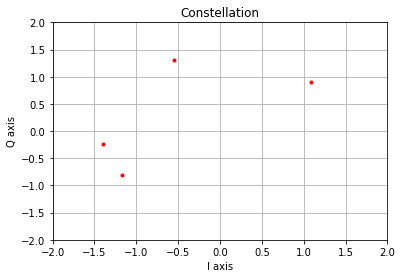

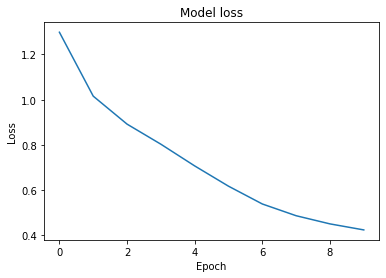

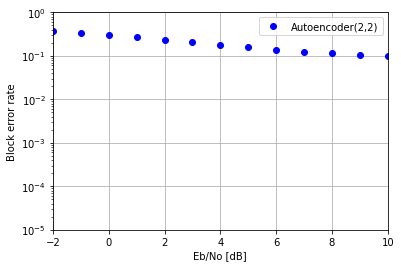

In [3]:
testModel( fixedEnergyConstraint=True)

# TO ADD : COMMENTS

### Question c)
Same as before, but with average power constraint

 ********* Testing autoencoder architecture ********* 
 
M: 4 	 k: 2 	 n: 2
 
(4000, 4)
(400, 4)
Average energy constraint
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
batch_normalization (BatchNo (None, 2)                 8         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 12        
__

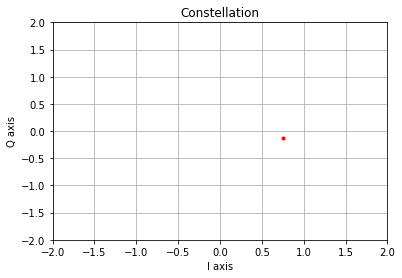

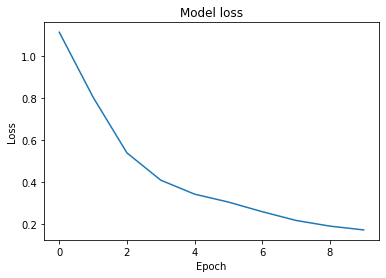

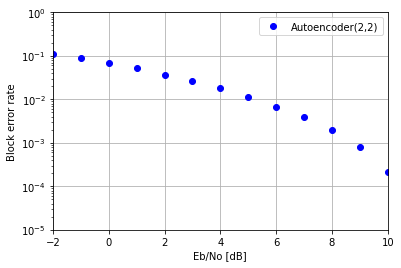

In [4]:
testModel(fixedEnergyConstraint = False)  #as we have here fixedEnergyConstraint = False

# TO ADD : COMMENTS

### Question d)
Same as before, but with different activation functions

    At first glance, I would think that the linear activation in the second layer is not necessary, and could be more useful by adding some nonlinearity. However, this was a false assumption (as it can be seen from the graphs). I also thought that the softmax output is important and should be kept, as the softmax function is a nice way to get a probability in output. And from the graphs, it also seems that it is better to keep the softmax.


 ********* Testing autoencoder architecture ********* 
 
M: 4 	 k: 2 	 n: 2
 
(4000, 4)
(400, 4)
--- Question d) ---
Test with no nonlinearity -input
Fixed energy constraint
Test with no nonlinearity in question d -output
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 10        
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 2)                 0         
___________________________________

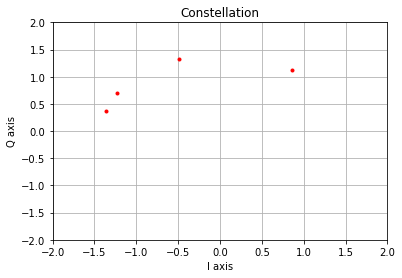

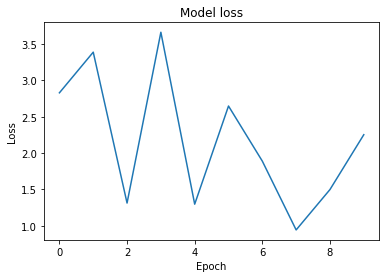

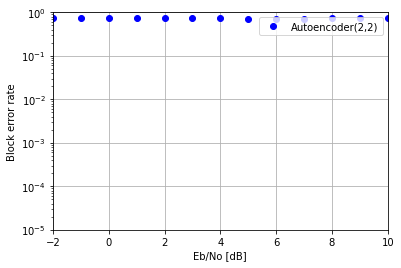

In [5]:
testModel( questionD = True, nonlinearD1 = False, nonlinearD2 = False) 
#Every dense layer is linear

    From the graphs above, we can see that if everything is linear, we get terrible results

 ********* Testing autoencoder architecture ********* 
 
M: 4 	 k: 2 	 n: 2
 
(4000, 4)
(400, 4)
--- Question d) ---
Test with no nonlinearity -input
Fixed energy constraint
Test with less nonlinearity in question d -output
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 10        
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 2)                 0         
_________________________________

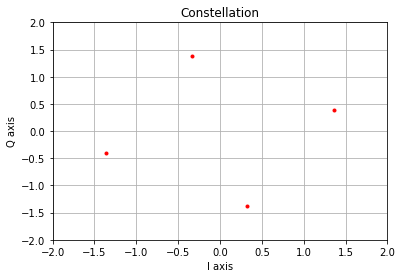

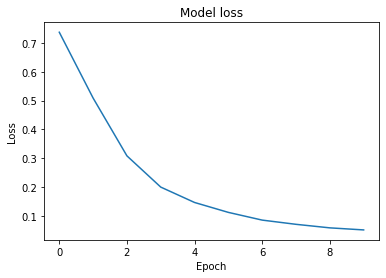

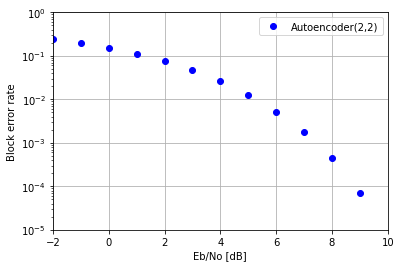

In [6]:
testModel( questionD = True, nonlinearD1 = False, nonlinearD2 = True)
#All dense layers are linear, excepted the last one (the softmax output)

    With only a softmax, the rest being linear, we get some quite decent results.

 ********* Testing autoencoder architecture ********* 
 
M: 4 	 k: 2 	 n: 2
 
(4000, 4)
(400, 4)
--- Question d) ---
Test with more nonlinearity -input
Fixed energy constraint
Test with no nonlinearity in question d -output
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 10        
_________________________________________________________________
lambda_3 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 2)                 0         
________________________________

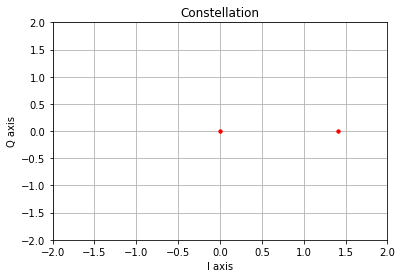

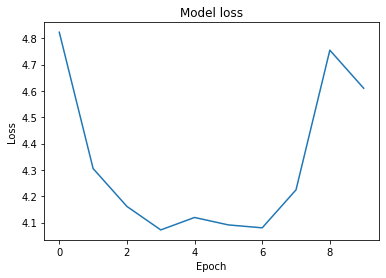

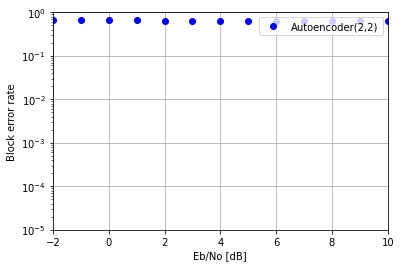

In [7]:
testModel( questionD = True, nonlinearD1 = True, nonlinearD2 = False)

    With non linearities only at the encoding phase, but no softmax, we get terrible results. 

 ********* Testing autoencoder architecture ********* 
 
M: 4 	 k: 2 	 n: 2
 
(4000, 4)
(400, 4)
--- Question d) ---
Test with more nonlinearity -input
Fixed energy constraint
Test with less nonlinearity in question d -output
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 10        
_________________________________________________________________
lambda_4 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_5 (GaussianNo (None, 2)                 0         
______________________________

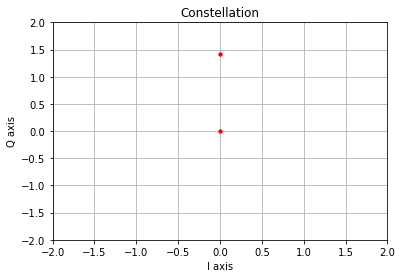

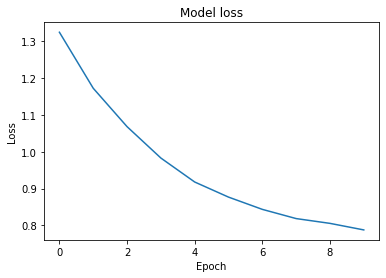

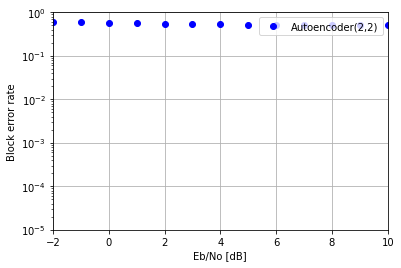

In [8]:
testModel( questionD = True, nonlinearD1 = True, nonlinearD2 = True)

    With only non linear activations, we get some quite bad results.

COMMENTS: results are very different than what was expected. Keeping the softmax output seems mandatory (to get a probability as an output). However, surprisingly, it seems that keeping some linear layers (with linear activation) is helpfull.

# To add : justification (with IPad photos)

### Question e)
Testing the influence of the number of layers on the model.

 ********* Testing autoencoder architecture ********* 
 
M: 4 	 k: 2 	 n: 2
 
(4000, 4)
(400, 4)
--- Question e) ---
Fixed energy constraint
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 10        
_________________________________________________________________
lambda_5 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_6 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_____________________________________________________

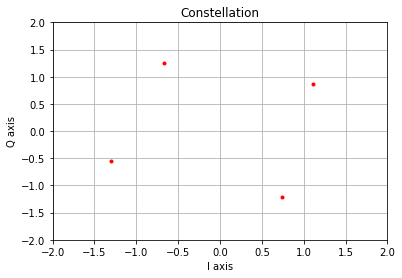

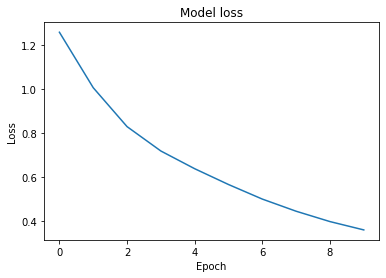

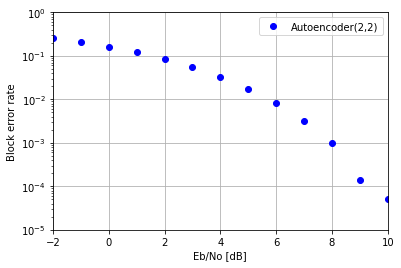

In [9]:
testModel(questionE = True,increaseNbrLayer = False)
    

 ********* Testing autoencoder architecture ********* 
 
M: 4 	 k: 2 	 n: 2
 
(4000, 4)
(400, 4)
--- Question e) ---
Fixed energy constraint
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 10        
_________________________________________________________________
lambda_6 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_7 (GaussianNo (None, 2)           

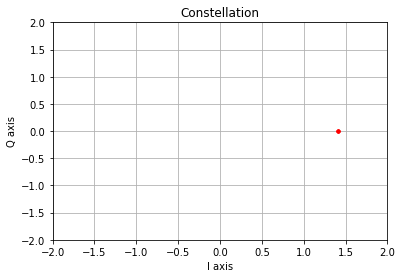

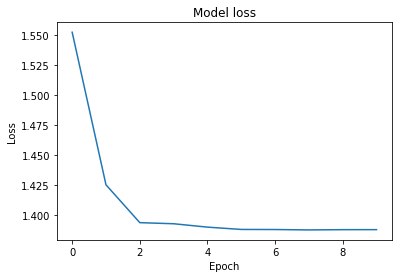

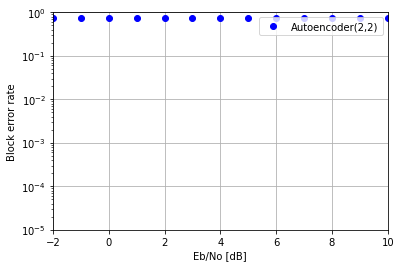

In [10]:
testModel(questionE = True,increaseNbrLayer = True)
    

        We can see from the graphs above that decreasing the number of layers does not change the output 
        (and can even  improve it), whereas adding layers seems to make the model less efficient...
# TO ADD : COMMENTS

### Question f)
Testing the influence of  <b> n </b>  and  <b> k </b> on the model.

 ********* Testing autoencoder architecture ********* 
 
M: 4 	 k: 2 	 n: 2
 
(4000, 4)
(400, 4)
Fixed energy constraint
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 10        
_________________________________________________________________
lambda_7 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_8 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 12        
___

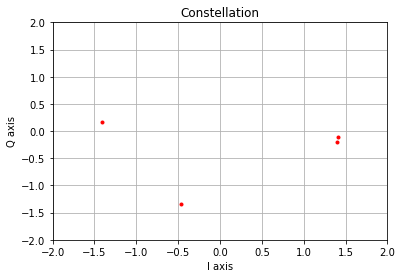

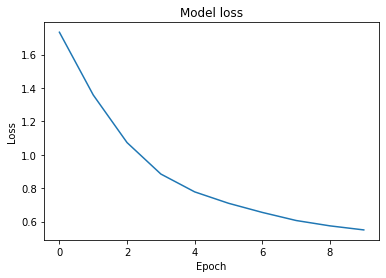

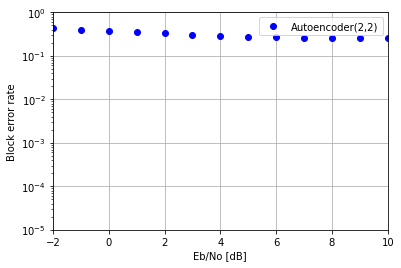

In [11]:
testModel(k= 2, n=2)

 ********* Testing autoencoder architecture ********* 
 
M: 4 	 k: 2 	 n: 4
 
(4000, 4)
(400, 4)
Fixed energy constraint
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 20        
_________________________________________________________________
lambda_8 (Lambda)            (None, 4)                 0         
_________________________________________________________________
gaussian_noise_9 (GaussianNo (None, 4)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 20        
___

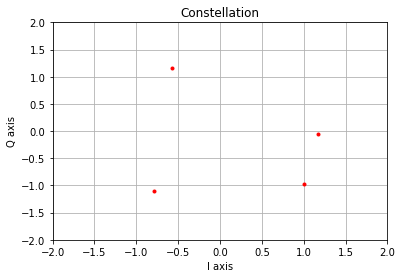

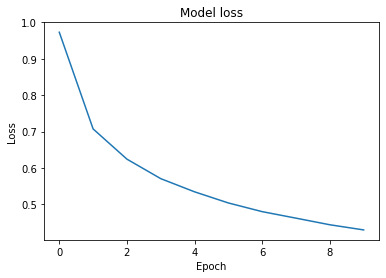

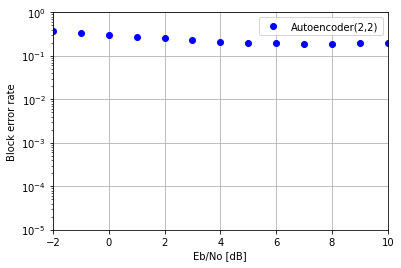

In [12]:
testModel(k= 2, n=4)

 ********* Testing autoencoder architecture ********* 
 
M: 16 	 k: 4 	 n: 2
 
(16000, 16)
(1600, 16)
Fixed energy constraint
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 16)]              0         
_________________________________________________________________
dense_39 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 34        
_________________________________________________________________
lambda_9 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_10 (GaussianN (None, 2)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 16)                48       

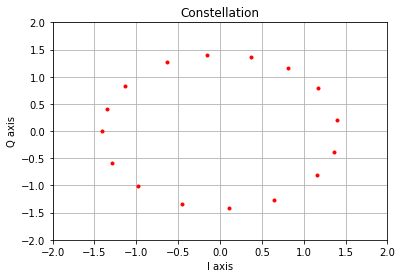

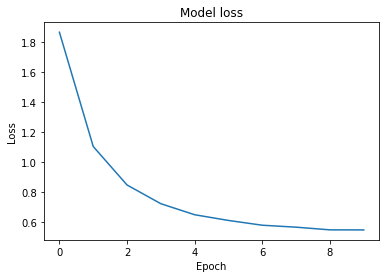

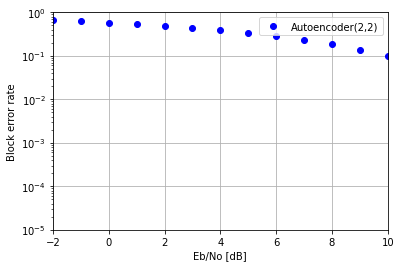

In [13]:
testModel(k= 4, n=2)

# TO ADD : COMMENTS